In [105]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import cv2
import h5py
import copy

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import autocorr_mat, get_lagplot, print_wise
from data_preprocessing.preprocessing import create_bins, get_firing_rate, cut_excess_timepoints, format_in_trials


In [4]:
exp_name = "paul_20250914"
data_path = f"{paths['livingstone_lab']}/Data/Data-Formatted/{exp_name}_experiment.mat"
d = loadmat(data_path)
stimuli = d["Stimuli"]
trials = d["Trials"]
print(stimuli.dtype.names)

('trial_number', 'serial_number', 'start_time', 'stop_time', 'latency', 'position', 'size_px', 'filename', 'subdir')


In [ ]:
mua_path = "/Volumes/LivingstoneLab/Data/Data-Neuropixels-Preprocessed/paul_250914/catgt_paul_250914_g0/paul_250914_g0_imec0/paul_250914-imec0-mua_cont.h5"

In [6]:
with h5py.File(mua_path, "r") as f:
    print(list(f.keys()))
    print(f["mua_cont"].shape)  # (1262371, 64)
    #print(f["unit_names"][:])  # convert with array.astype(int)
    mua_cont = f["mua_cont"][:]
 

['mua_cont', 'mua_cont-meta']
(1267347, 383)


In [7]:
stimuli_names = np.concatenate(np.unique(stimuli["filename"]))
stimuli_names = [
    x[:] for x in stimuli_names
]  # because we have to take all the chars in the element
print(stimuli_names)

['anna1_10s.mp4', 'anna1_10s_rev.mp4', 'anna1_to_guy1_10s.mp4', 'anna1_to_guy1_10s_rev.mp4', 'anna1_to_roscoe_10s.mp4', 'anna2_to_marge_10s.mp4', 'anna2_to_marge_10s_rev.mp4', 'rubin2_to_girl1_10s.mp4', 'rubin2_to_girl1_10s_rev.mp4', 'rubin2a_10s.mp4', 'rubin2a_rev.mp4', 'rubin_to_venus_10s.mp4', 'rubin_to_venus_10s_rev.mp4']


In [8]:
s = np.concatenate(stimuli["filename"])
file_list = [str(x[0]) for x in s]

In [9]:
rasters = mua_cont

In [106]:
len_window_firing_rate = 1000 / 30  # in ms
final_res_neural, final_res_gaze = format_in_trials(file_list, len_window_firing_rate, rasters, trials, stimuli)


14:30:54 - Warning! rubin2a_rev.mp4 has different time-points across trials [301, 301, 301, 300, 300]
14:30:54 - Warning! anna2_to_marge_10s_rev.mp4 has different time-points across trials [301, 302]
14:30:54 - Warning! rubin2a_10s.mp4 has different time-points across trials [302, 301]
14:30:54 - Warning! anna2_to_marge_10s.mp4 has different time-points across trials [301, 301, 302]
14:30:54 - Warning! rubin2_to_girl1_10s.mp4 has different time-points across trials [301, 302]
14:30:54 - Warning! rubin2a_rev.mp4 has different time-points across trials [301, 301, 301, 300, 300]
14:30:54 - Warning! anna2_to_marge_10s_rev.mp4 has different time-points across trials [301, 302]
14:30:54 - Warning! rubin2a_10s.mp4 has different time-points across trials [302, 301]
14:30:54 - Warning! anna2_to_marge_10s.mp4 has different time-points across trials [301, 301, 302]
14:30:54 - Warning! rubin2_to_girl1_10s.mp4 has different time-points across trials [301, 302]


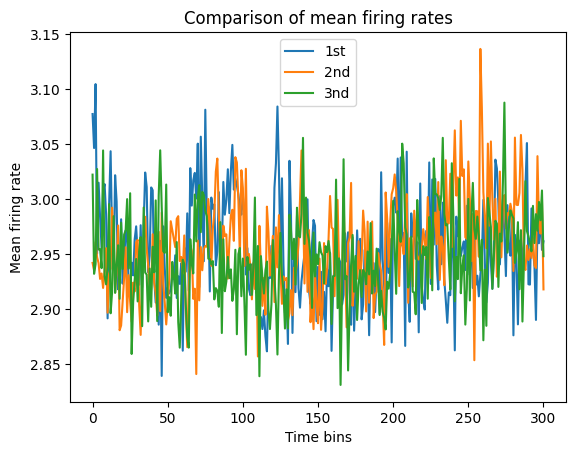

In [107]:
plt.plot(np.mean(final_res_neural["anna2_to_marge_10s.mp4"][:40, :, 0], axis=0), label="1st")
plt.plot(np.mean(final_res_neural["anna2_to_marge_10s.mp4"][:40, :, 1], axis=0), label="2nd")
plt.plot(np.mean(final_res_neural["anna2_to_marge_10s.mp4"][:40, :, 2], axis=0), label="3nd")
plt.legend()
plt.xlabel("Time bins")
plt.ylabel("Mean firing rate")
plt.title("Comparison of mean firing rates")
plt.show()

Text(0, 0.5, 'Time bins')

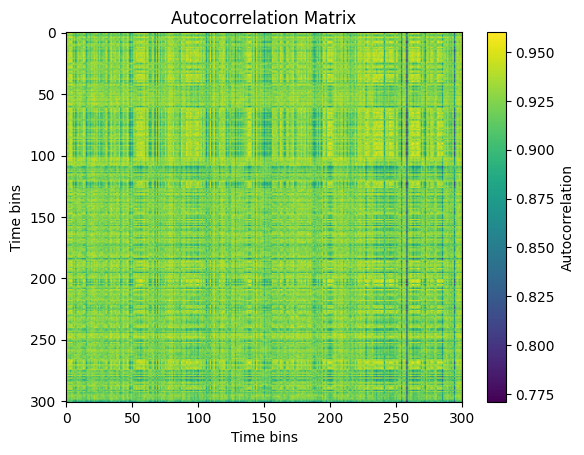

In [108]:
m = autocorr_mat(final_res_neural["anna2_to_marge_10s.mp4"][:, :, 0], final_res_neural["anna2_to_marge_10s.mp4"][:, :, 1]) #,final_res["anna2_to_marge_10s_rev.mp4"][:, :, 0][::-1].T )
plt.imshow(m, aspect='auto', cmap='viridis')
plt.colorbar(label='Autocorrelation')
plt.title("Autocorrelation Matrix")
plt.xlabel("Time bins")
plt.ylabel("Time bins")

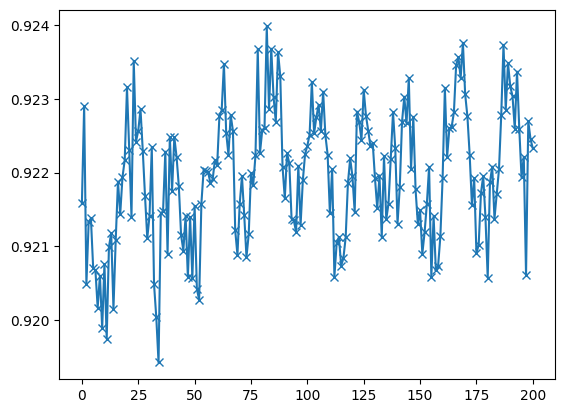

In [109]:
lagplot = get_lagplot(m, max_lag=100)
plt.plot(lagplot, marker='x')

Text(0, 0.5, 'y position')

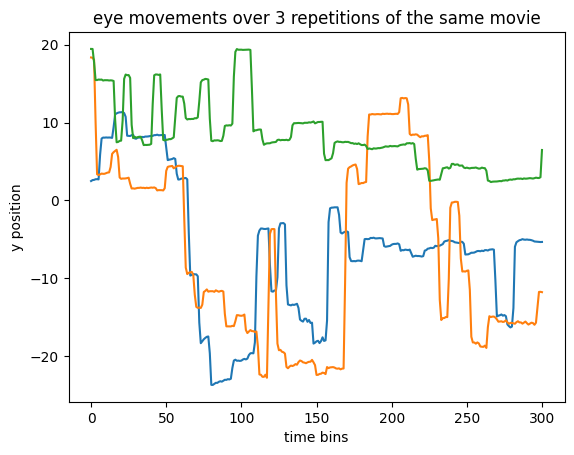

In [110]:
# plt.plot(np.mean(final_res_gaze["anna2_to_marge_10s.mp4"][1, :, 0], axis=0), label="anna2_to_marge_10s.mp4")
# plt.plot(np.mean(final_res_gaze["anna2_to_marge_10s.mp4"][1, :, 1], axis=0), label="anna2_to_marge_10s.mp4")
# plt.plot(np.mean(final_res_gaze["anna2_to_marge_10s.mp4"][1, :, 2], axis=0), label="anna2_to_marge_10s.mp4")

plt.plot(final_res_gaze["anna2_to_marge_10s.mp4"][1, :, 0], label="anna2_to_marge_10s.mp4")
plt.plot(final_res_gaze["anna2_to_marge_10s.mp4"][1, :, 1], label="anna2_to_marge_10s.mp4")
plt.plot(final_res_gaze["anna2_to_marge_10s.mp4"][1, :, 2], label="anna2_to_marge_10s.mp4")
plt.title("eye movements over 3 repetitions of the same movie")
plt.xlabel("time bins")
plt.ylabel("y position")

Text(0, 0.5, 'average x, y eye position')

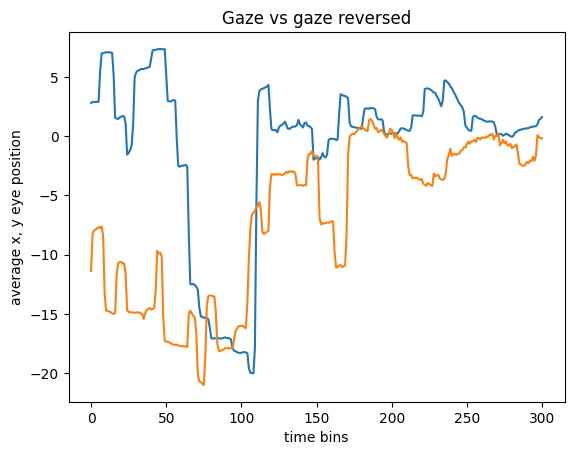

In [111]:
plt.plot(np.mean(final_res_gaze["anna2_to_marge_10s.mp4"][:2, :, 0], axis=0), label="anna2_to_marge_10s.mp4")
plt.plot(np.mean(final_res_gaze["anna2_to_marge_10s_rev.mp4"][:2, :, 0][::-1], axis=0), label="anna2_to_marge_10s_rev.mp4")
plt.title("Gaze vs gaze reversed")
plt.xlabel("time bins")
plt.ylabel("average x, y eye position")

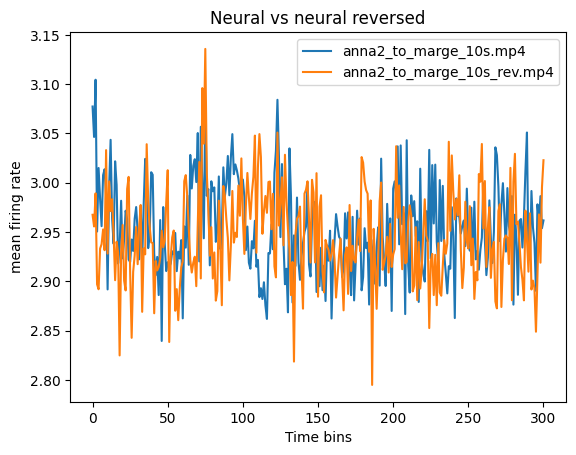

In [112]:
#fig, axes = plt.subplots(5, 3, figsize=(10, 6))
#plt.plot(anna2_to_marge_10s.mp4")
# plot one video on top of the other inverted
plt.plot(np.mean(final_res_neural["anna2_to_marge_10s.mp4"][:40, :, 0], axis=0), label="anna2_to_marge_10s.mp4")
plt.plot(np.mean(final_res_neural["anna2_to_marge_10s_rev.mp4"][:40, :, 0][::-1], axis=0), label="anna2_to_marge_10s_rev.mp4")
plt.legend()
plt.xlabel("Time bins")
plt.ylabel("mean firing rate")
plt.title("Neural vs neural reversed")
plt.show()

In [113]:
video_dir = f"{paths["livingstone_lab"]}/Stimuli/faceswap_4"

In [ ]:
import sounddevice as sd
import numpy as np
def play_sound(amplitude):
    fs = 44100  # Sample rate (Hz)
    duration = 0.3  # seconds
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    modulator = 1 + amplitude * np.sin(2 * np.pi * f_mod * t)
    sound = 0.5 * np.sin(2 * np.pi * 440 * t)  # 440 Hz sine wave

    sd.play(sound, samplerate=fs)
    sd.wait()  # Wait until sound finishes playing

play_sound(200)

In [ ]:
import numpy as np
import sounddevice as sd

def firing_rate_to_noise(firing_rate, fs=44100, duration=0.5, play=True):
    """
    Generate 0.5 s of white noise whose amplitude scales with a firing rate.

    Parameters
    ----------
    firing_rate : float
        Input firing rate (arbitrary units, e.g. spikes/s). 
        The amplitude will be proportional to this value.
    fs : int
        Sampling rate (Hz).
    duration : float
        Duration of the sound in seconds (default: 0.5).
    play : bool
        If True, plays the sound. Otherwise returns the waveform.

    Returns
    -------
    sound : np.ndarray
        The generated noise waveform.
    """
    # Normalize firing rate to [0, 1] (you can tune this scaling)
    a = np.clip(firing_rate / 100.0, 0, 1)  # assume 100 Hz max for scaling

    # Generate white noise
    n_samples = int(fs * duration)
    noise = np.random.uniform(-1, 1, n_samples)

    # Modulate amplitude by firing rate
    sound = a * noise

    if play:
        sd.play(sound, samplerate=fs)
        sd.wait()
    return sound

In [58]:
from scipy.stats import zscore

In [82]:
zscore(n[:20, :], axis=0).shape

(20, 302)

In [114]:
from IPython.display import clear_output

curr_file = "rubin_to_venus_10s_rev.mp4"
video_file = f"/Volumes/LivingstoneLab/Stimuli/faceswap_4/{curr_file}"
ctrl_video_file = f"/Users/tizianocausin/figimages/temp/250914-depths{curr_file}.avi"
rep = 0
%matplotlib inline
cap = cv2.VideoCapture(video_file)
ctrl_cap = cv2.VideoCapture(ctrl_video_file)
print(f"Total number of frames: {frame_count}")
timestamps = []
g = copy.deepcopy(final_res_gaze[curr_file][:,:,rep])
g[0,:] = 960 + g[0,:]*32 
g[1,:] = 540 - g[1,:]*32
n = copy.deepcopy(final_res_neural[curr_file][:40, :, rep])

n_z = zscore(n[:20, :], axis=0)
n_mean_z = zscore(np.mean(n[:20, :], axis=0))
for i in range(g.shape[1]):
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ret, ctrl_frame = ctrl_cap.read()
    ctrl_frame = cv2.cvtColor(ctrl_frame, cv2.COLOR_BGR2RGB)
    if not ret:
        break
   #frame = cv2.resize(frame, (192, 108))
    
    # fig = plt.imshow(frame)
    # plt.scatter(g[0, i], g[1, i], s = 50)
    # plt.pause(1)
    # plt.close(fig)
    fig, ax = plt.subplots(1, 3, figsize=(8, 4))
    ax[0].imshow(frame)
    ax[0].scatter(g[0, i], g[1, i], s=20, c='r')
    firing_rate_to_noise(n_mean_z[i], fs=44100, duration=0.05, play=True)
    ax[1].imshow(ctrl_frame)
    ax[2].plot(n_mean_z[:i])
    plt.show()
    plt.close(fig)
    clear_output(wait=True)
cap.release()

KeyboardInterrupt: 